In [1]:
import sys
sys.path.insert(0,'..')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
from tqdm.notebook import tqdm

from resnet import resnet18
from vgg import VGG
from relu import ReLUAlpha


def init(batchnorm, relu=0):
    if batchnorm:
        net = VGG('VGG11', batch_norm=True, relu_fn=lambda: ReLUAlpha(relu)).to(device)
    else:
        net = VGG('VGG11', relu_fn=lambda: ReLUAlpha(relu)).to(device)
    return net

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

def copy_params(net1, net2):
    params1 = net1.named_parameters()
    params2 = net2.named_parameters()

    dict_params2 = dict(params2)
    for name, param in params1:
        if name in dict_params2:
            dict_params2[name].data.copy_(param.data)

def rebuild_model(net1, net2):
    net1.apply(weight_reset)
    copy_params(net1, net2)
            
def build_models(batchnorm, precision=32):
    net1 = init(batchnorm, 0)
    net2 = init(batchnorm, 1)
    copy_params(net1, net2)

    for net in [net1, net2]:
        net.to(device)
        if precision == 16:
            net.half()
        if precision == 64:
            net = net.double()
        
    return net1, net2

def get_cifar10_train_loader():
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    return torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [2]:
nb_experiments = 100 #full paper experiment: nb_experiments = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    cudnn.benchmark = False
    # Deterministic convolutions
    torch.backends.cudnn.deterministic = True

trainloader = get_cifar10_train_loader()
df = pd.DataFrame(columns=["network", "batchnorm", "same", "precision", "batch_idx", "run_id",
                           "net1_L1", "net1_L2", "net2_L1", "net2_L2", "diff_L1", "diff_L2"])

for precision in tqdm([16, 32], desc='precision'):
    for batchnorm in tqdm([False, True], desc='batchnorm', leave=False):
        count = 0
        net1, net2 = build_models(batchnorm, precision)
        opt = optim.SGD([{'params': net1.parameters()}, {'params': net2.parameters()}], lr=0)
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            rebuild_model(net1, net2)
            # Optimizers are just used to free the gradients accumulated during the backward pass
            # No optimization step is performed
            opt.zero_grad()
            for i, (x, y) in enumerate(trainloader):
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    x = x.double()
                y = y.to(device)
                same = True
                y1, y2 = net1(x), net2(x)
                loss = nn.CrossEntropyLoss()(y1, y) + nn.CrossEntropyLoss()(y2, y)
                loss.backward()
                if not torch.equal(net1.features[0].weight.grad, net2.features[0].weight.grad):
                    same = False
                diff = net1.features[0].weight.grad - net2.features[0].weight.grad
                df = df.append({"run_id": run_id,
                                "network": 'resnet',
                                "batchnorm": batchnorm,
                                "same": same,
                                "precision": precision,
                                "net1_L1": torch.linalg.norm(net1.features[0].weight.grad.view(-1), 1).item(),
                                "net1_L2": torch.linalg.norm(net1.features[0].weight.grad.view(-1), 2).item(),
                                "net2_L1": torch.linalg.norm(net2.features[0].weight.grad.view(-1), 1).item(),
                                "net2_L2": torch.linalg.norm(net2.features[0].weight.grad.view(-1), 2).item(),
                                "diff_L1": torch.linalg.norm(diff.view(-1), 1),
                                "diff_L2": torch.linalg.norm(diff.view(-1), 2),
                                "batch_idx": i}, ignore_index=True)
                if same == False:
                    break

df.to_csv('volume_estimation_sample_vgg11.csv')

Files already downloaded and verified


precision:   0%|          | 0/2 [00:00<?, ?it/s]

batchnorm:   0%|          | 0/2 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

batchnorm:   0%|          | 0/2 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
df = pd.read_csv('../paper_results/section_4/cifar10/vgg11/volume_estimation_sample_vgg11.csv')

In [3]:
import matplotlib.pyplot as plt

def prepare_volume_plot(df, max_size, batch_size):
    dfs = []
    #for precision in [16, 32, 64]:
    for precision in [16, 32]:
        tmp = df[df['precision'] == precision]
        max_len = len(tmp.run_id.unique())
        tmp = tmp[['batch_idx', 'same']].groupby(['batch_idx']).sum().reset_index()
        tmp['div'] = (max_len-tmp['same'])/max_len
        for i in range(tmp.batch_idx.count(), max_size):
            tmp = tmp.append({"div": 1.,
                                "same": max_len,
                                "batch_idx": i}, ignore_index=True)
        tmp['batch_idx'] = tmp['batch_idx'] * batch_size
        tmp = tmp.astype({"div":float})
        dfs.append(tmp)
    #return dfs[0], dfs[1], dfs[2]
    return dfs[0], dfs[1]

def plot_volume_estimation(df, max_size, batch_size=128):
    #df16, df32, df64 = prepare_volume_plot(df, max_size, batch_size)
    df16, df32 = prepare_volume_plot(df, max_size, batch_size)
    plt.figure(figsize=(15,5))
    #plt.plot(df64['batch_idx'], df64['div'].values, label='64 bits')
    plt.plot(df32['batch_idx'], df32['div'].values, label='32 bits')
    plt.plot(df16['batch_idx'], df16['div'].values, label='16 bits')
    #plt.fill_between(df64['batch_idx'].values, df64['div'].values, alpha=.3)
    plt.fill_between(df32['batch_idx'].values, df32['div'].values, alpha=0.3)
    plt.fill_between(df16['batch_idx'].values, df16['div'].values, alpha=.3)
    leg = plt.legend(title="Precision", fontsize='25', title_fontsize='25', loc='lower right')
    plt.xlabel('sample size', fontsize='25');
    plt.ylabel('Ratio of ' + r'$\theta \in S$', fontsize='30');plt.yticks(fontsize='25');
    plt.xticks(fontsize='25');
    for line in leg.get_lines():
        line.set_linewidth(10.0)

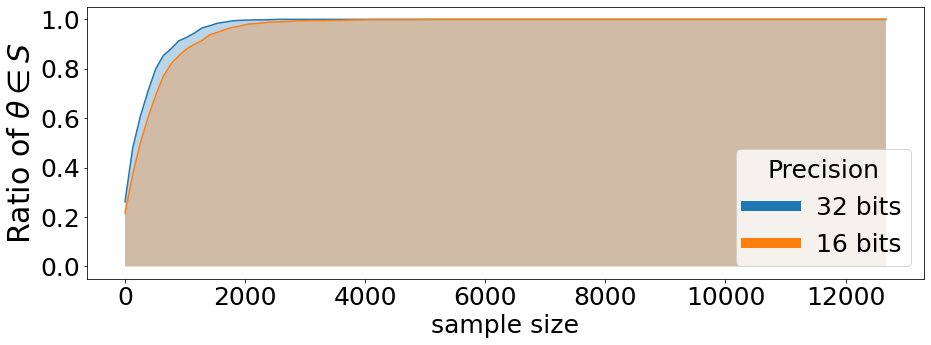

In [4]:
plot_volume_estimation(df[df['batchnorm']==True], 100, batch_size=128)

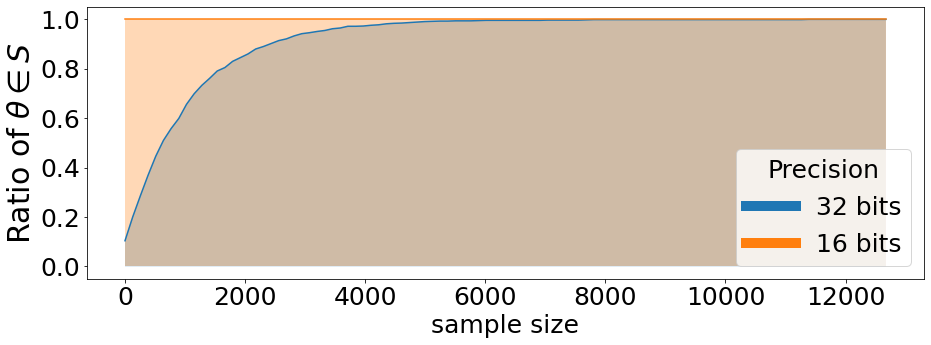

In [5]:
plot_volume_estimation(df[df['batchnorm']==False], 100, batch_size=128)